In [48]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sentence_transformers import SentenceTransformer, util
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional, Reshape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
print(tf.__version__)

2.15.0


In [50]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('E:/Machine Learning', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('E:/Machine Learning', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [51]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [52]:
stop_words

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '``',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'doe',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'ha',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn

### 1_ Read and format the data

We will train the word2vec skip-gram model on the summaries.  
First, we create a Tokenizer function that cleans and tokenize the summaries. The main difference with the pre-processing of the previous part is that we don't want to lemmatize the documents. All the different words of our corpus (except the stopwords and the special characters) will have its own vector.

In [53]:
# clean and tokenize the text -> we don't want to lemmatize
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z]+",'',w) != ''] 
    return filtered_sentence

In [54]:
SUMMARY_PATH = 'E:/Machine Learning/MutualFundSummary'
fund_names, summaries = get_data(SUMMARY_PATH)

In [55]:
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

In [56]:
text_words[:20]

array(['ab', 'market', 'income', 'portfolio', 'investment', 'objective',
       'fund', "'s", 'investment', 'objective', 'seek', 'current',
       'income', 'consideration', 'capital', 'appreciation', 'fees',
       'expenses', 'fund', 'table'], dtype='<U44')

### 2_ Briefly visualize the text data set.

In [57]:
from wordcloud import WordCloud

<b>Build a word cloud figure</b>

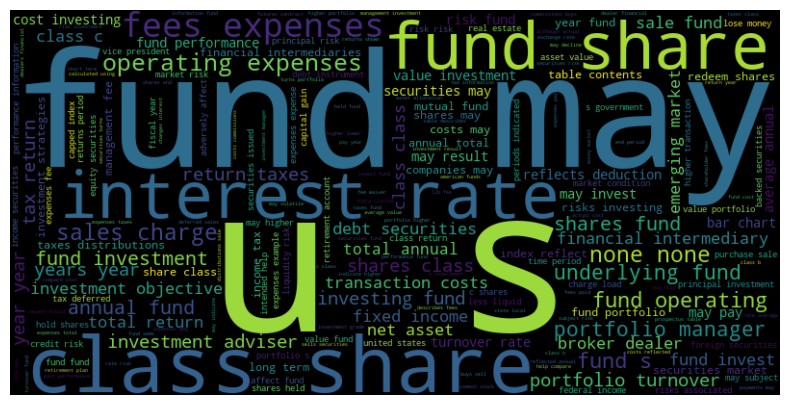

In [58]:
text_data = ' '.join([word for summary in summaries for word in tokenizer(summary)])
wordcloud = WordCloud(width=800, height=400).generate(text_data)

# show the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Bubble Chart**

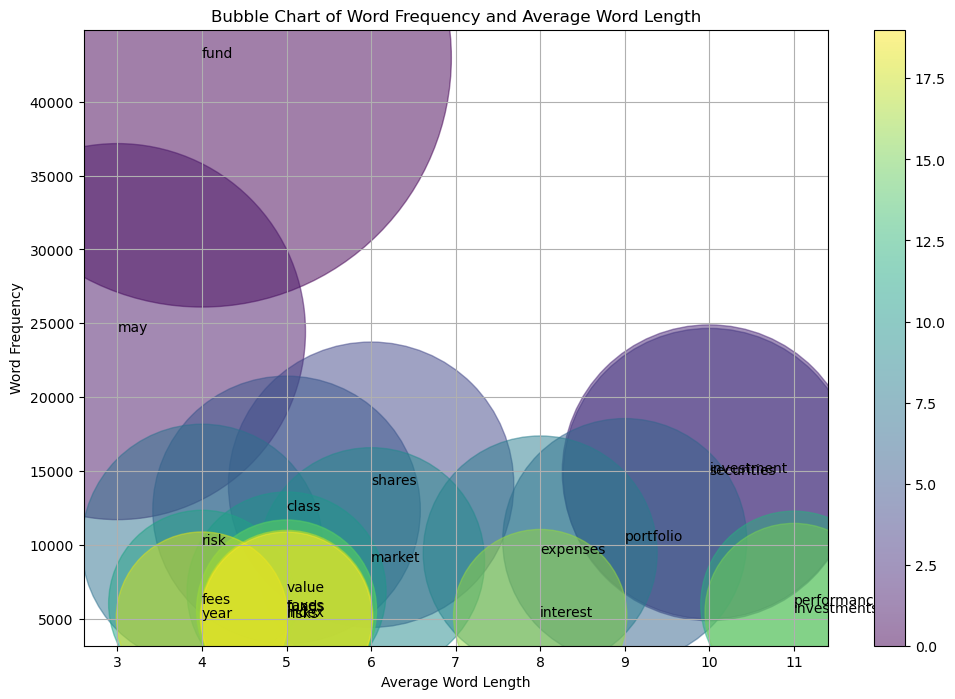

In [59]:
from collections import Counter

word_counts = Counter(text_data.split())

#Here we choose the most common 20 words
top_words = word_counts.most_common(20)

words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]
average_lengths = [len(word) for word in words]

x = average_lengths   
y = frequencies       
sizes = np.array(frequencies) * 3  

#When using the color mapping, the word with the highest frequency (and hence the largest bubble) 
#is assigned the lowest value on the color bar
colors = np.arange(len(top_words))  

plt.figure(figsize=(12, 8))
scatter = plt.scatter(x, y, s=sizes, c=colors, cmap='viridis', alpha=0.5)
plt.xlabel('Average Word Length')
plt.ylabel('Word Frequency')
plt.title('Bubble Chart of Word Frequency and Average Word Length')
plt.grid(True)
plt.colorbar(scatter)  

for i, txt in enumerate(words):
    plt.annotate(txt, (x[i], y[i]))

plt.show()

**Pie Chart**

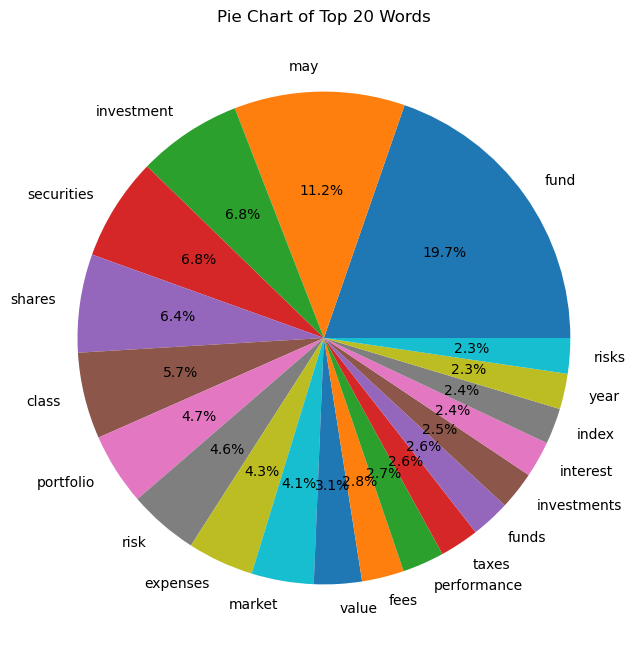

In [60]:
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=words, autopct='%1.1f%%')
plt.title('Pie Chart of Top 20 Words')
plt.show()

### 3_ Process Skip-Gram model Input

* We set the dimension of our word vectors to 50. This is the embedding size and therefore the size of our hidden layer.
* We only consider the 5000 most frequent words.
* we set the window size to 4.
* Here we will only take 4 (num_skips) randomly chosen words in the local context of each word to build the input. (instead of all the local context as shown in the above example).

In [61]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 3 # The model will go through all the data three times

# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 4 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [62]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [63]:
count

[('UNK', -1),
 ('fund', 42972),
 ('may', 24436),
 ('investment', 14942),
 ('securities', 14763),
 ('shares', 14073),
 ('class', 12370),
 ('portfolio', 10293),
 ('risk', 10021),
 ('expenses', 9458),
 ('market', 8901),
 ('value', 6847),
 ('fees', 6027),
 ('performance', 5987),
 ('taxes', 5605),
 ('funds', 5587),
 ('investments', 5449),
 ('interest', 5186),
 ('index', 5147),
 ('year', 5078),
 ('risks', 5073),
 ('returns', 4968),
 ('investing', 4805),
 ('companies', 4598),
 ('financial', 4588),
 ('none', 4214),
 ('income', 4115),
 ('return', 4105),
 ('underlying', 4096),
 ("'s", 4044),
 ('annual', 3939),
 ('price', 3860),
 ('information', 3818),
 ('years', 3799),
 ('markets', 3612),
 ('invest', 3461),
 ('management', 3345),
 ('costs', 3311),
 ('higher', 3307),
 ('foreign', 3262),
 ('operating', 3258),
 ('rates', 3248),
 ('total', 3219),
 ('u.s.', 3212),
 ('rate', 3117),
 ('assets', 3044),
 ('also', 3034),
 ('sales', 3026),
 ('periods', 3002),
 ('table', 2973),
 ('example', 2960),
 ('purcha

In [64]:
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [65]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 3449


In [66]:
# create data
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [67]:
print(data[:20])

[1284, 10, 26, 7, 3, 123, 1, 29, 3, 123, 354, 181, 26, 2553, 73, 581, 12, 9, 1, 49]


We create a function that translate a word index to its one-hot representation (vector of zero with 1 in the word id position)

In [68]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [69]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### 4_ Train the skip-gram model
We are ready to create and train the model.

In [70]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [71]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [72]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3449)]            0         
                                                                 
 dense (Dense)               (None, 50)                172500    
                                                                 
 dense_1 (Dense)             (None, 3449)              175899    
                                                                 
Total params: 348399 (1.33 MB)
Trainable params: 348399 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

C:\Users\Sky\AppData\Local\Temp\ipykernel_15080\1429867129.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/3

7481/7481 [==============================] - 71s 9ms/step - loss: 0.0125
Epoch 2/3
7481/7481 [==============================] - 70s 9ms/step - loss: 0.0021
Epoch 3/3
7481/7481 [==============================] - 70s 9ms/step - loss: 0.0020


<h3>5_ Use the encoder to vectorize</h3><br>
The autoencoder has been trained, we can now use the matrix and bias of the encoder (input + hidden layer) to build our word representations !

In [74]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [75]:
word2vec = {w:vecotrize(w) for w in word2id.keys()} 

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


In [76]:
# We can save the word2vec dictionary to reuse it later.
our_word2vec = 'word2vec_perso_3epochs.txt'

In [77]:
save_word2vec(our_word2vec)

<h3>6_Visualization</h3><br>
Now that we created our map, we can visualize the words!
We want to observe that words in the same context are spatially close.

In [78]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [79]:
words_neighbors_1 = get_n_closer('expenses', 10, word2vec)
print('words close to expenses : ' +str(', '.join(words_neighbors_1)))
words_neighbors_2 = get_n_closer('derivatives', 10, word2vec)
print('words close to derivatives : ' +str(', '.join(words_neighbors_2)))

words close to expenses : expenses, acquired, describes, remain, waiver, servicing, shareholder, reimbursement, expenses1, exceed
words close to derivatives : derivatives, leverage, loss, derivative, addition, significant, collateral, highly, liquidity, losses


In [80]:
# fit the TSNE dimenstion reduction model
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(3449, 50)
(3449, 2)


In [81]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [82]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])
    
    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

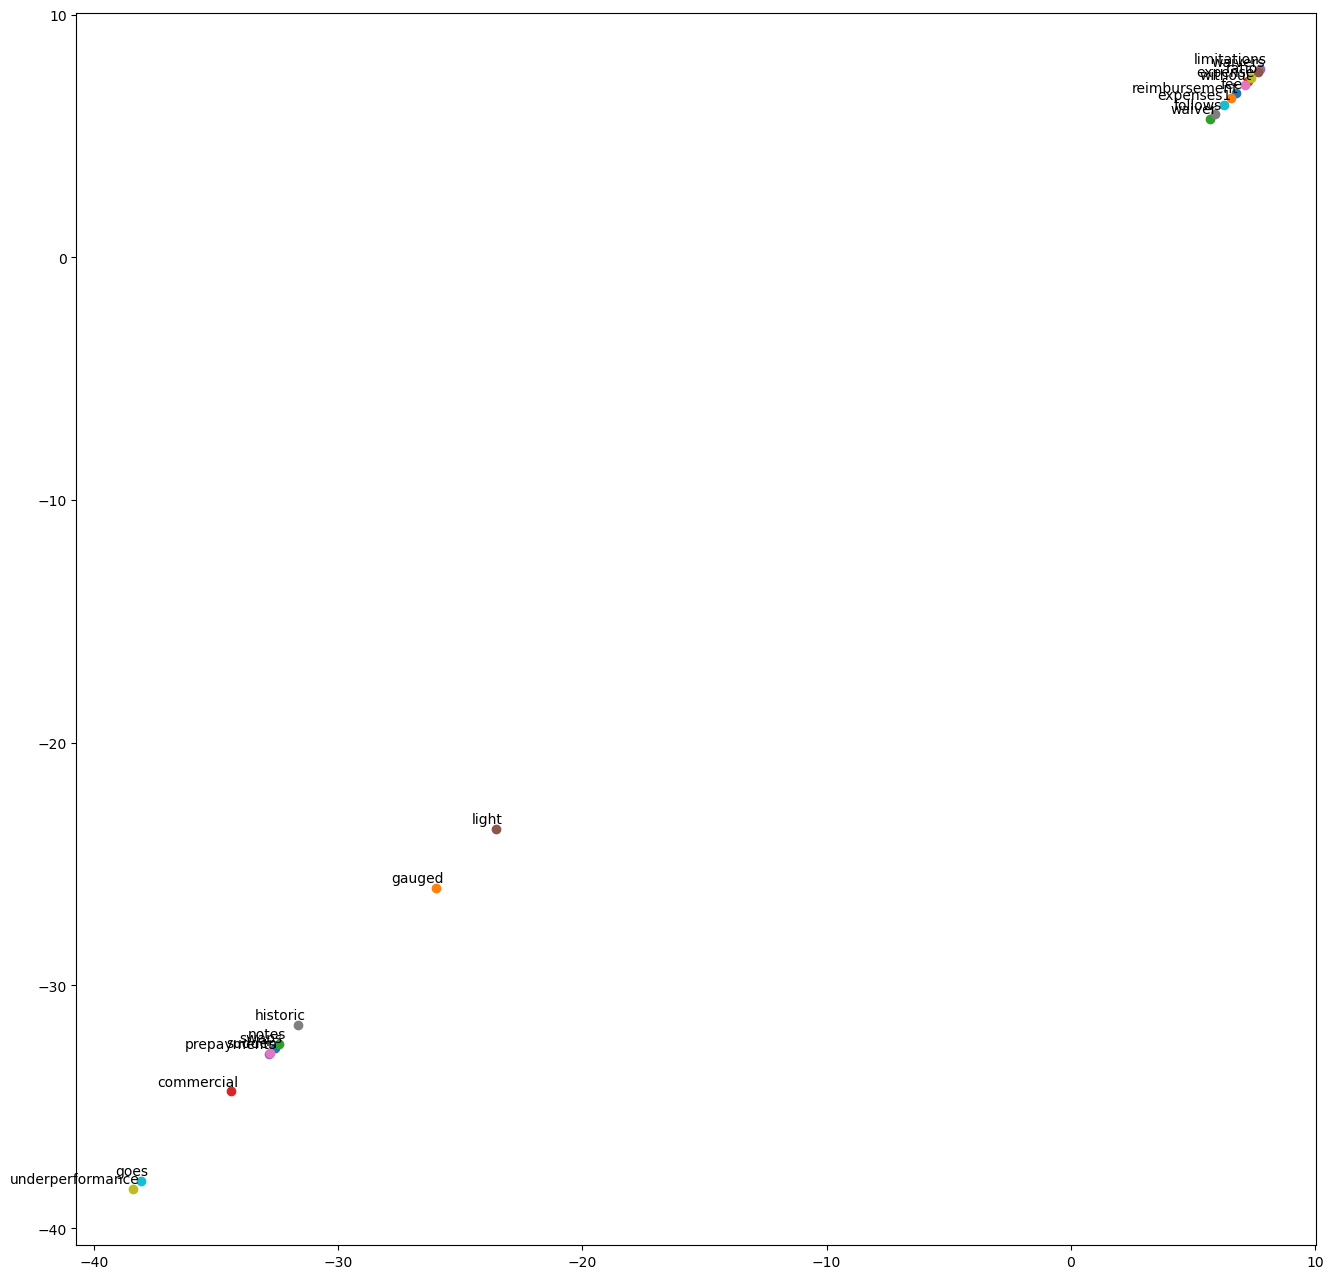

In [83]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

# C- Sentence extraction

<h3>Objective</h3>
Our objective for the next two parts is to create a model that will be able to predict if a fund uses derivatives based on the summary.
The first step is to extract from the summaries the sentences that deals with derivatives.

<h3> 1_ Create a knowledge base </h3>

In [164]:
key_words = ['equity', 'equities', 'stock', 'fixed', 'income', 'bond', 'duration', 'credit', 'balanced', 'balance', 'asset', 'investment', 'fees', 'low', 'fund', 'long', 'risk', 'return', 'portfolio', 'shares', 'underlying', 'strategy']

In [165]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words):
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [166]:
word2vec = load_word2vec(our_word2vec)

In [171]:
knowledge_base = create_knowledge_base(7, word2vec, key_words)

In [211]:
print(knowledge_base)

{'recent', 'global', 'inflation', 'employed', 'exempt', 'non-hedging', 'personal', 'neutral', 'derived', 'preservation', 'estate', 'risk', 'holdings', 'prevent', 'additionally', 'tax', 'processed', 'per', 'r6', 'fees', 'process', 'e.g.', 'marginal', 'consequences', 'gaining', 'servicing', 'correspond', 'monetary', 'low', 'derivative', 'universe', 'quality', 'approximately', 'credit', 'default', 'investment', 'gains', 'underperform', 'janushenderson.com/performance', 'began', 'specific', 'opportunities', 'financially', 'results', 'visiting', 'greece', 'earnings', 'duration', 'lack', 'paid', 'fixed-income', 'reimburse', 'objectives', 'common', 'aggregated', 'combination', 'start', 'ticker', 'sovereign', 'iico', 'declines', 'determining', 'fixed', 'representatives', 'lowest', 'series', 'prior', 'shares', 'designed', 'top-down', 'long', 'b', 'equity', 'counterparty', 'prevailing', 'subadvisor', 'stock', 'yields', 'uses', '7th', 'positive', 'quarterly', 'bond', 'shift', 'practices', 'millio

### 2_ Scoring function

The objective here is to score each sentence accordingly to their distance to the knowledge base. In order to extract the sentences that deals with the use of derivatives from the summaries. <br>
There is an infinite way of doing this scoring (see entity linking paper). We will implement 2 scoring functions and compare the performance of the overall extraction framework.

In [267]:
SUMMARY_LABELS_PATH = 'E:/Machine Learning/MutualFundLabels.csv'

In [268]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()
print(len(df))
# We drop the four Long Short Funds (High Risk) and another one fund of another type (five in total)
labels_to_preserve = ['Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)', 'Equity Long Only (Low Risk)']
df_filtered = df[df['Ivestment Strategy'].isin(labels_to_preserve)]
print(len(df_filtered))
df_filtered.head()

466
461


,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,summary
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,American Funds College 2030 Fund\n\nInvestment...


<b>a_ Using distances</b><br>
A first method to extract the sentences dealing with derivaties could be to take the distance between the barycentre of the sentence and the words in the knwoldege base. We create the distance score by averaging the n_closer smaller distances.

We should not forget that some words (the ones with low frequencies) are not in our word2vec mapping so, if there are less than n_reject vectorisable vectors in the sentence, we drop the sentence.

Finally, we can choose the number of sentences we want to extract (num_sent).

In [269]:
sentence_barycentre = np.zeros(embedding_size)

In [270]:
def extract_sentence_distance(summary,knowledge,n_closer,n_reject,num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # loop over the sentences
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)
        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens:
            try:
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError:
                pass
            except:
                raise
                
        if effective_len <= n_reject:
            sentence_scores.append(1)
            
        else:
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre,word2vec[key_word]) for key_word in key_words]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
        # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
        sentence_scores, sentences = zip(*sorted(zip(sentence_scores,sentences)))
        top_sentences = sentences[:num_sent]
        return ' '.join(top_sentences)

In [271]:
df = df_filtered.copy()
df['invstrat_sentences_distance'] = df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

<b>b_ Match extraction</b><br>
The second method is simply to count the number of words that are in the intersection of the knowledge base and the sentence.
This scoring function is highly dependent on the number of neighbours  chose to create the knowledge base.

# D_ Information extraction using deep classifiers

<b>Objective</b><br>
In this section we will use the sentences that we extracted in the previous section to train 2 deep learning models aimed at predicting which investment strategy a mutual fund adopts based on its summary.

<h3>1_ Format data</h3><br>
In this paragraph we will prepare the corpus, the dependent variable and split the data to a training set, a validation set and a testing set. <br>
The independent variable (the corpus) is the list of the sentences extracted in the previous section for each fund.

In [363]:
X = df['invstrat_sentences_distance'].values

In [364]:
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
X[0][:100]

'american funds college fund investment objectives fund seek achieve following objectives varying deg'

In [365]:
y = df['Ivestment Strategy'].values

In [275]:
y

array(['Balanced Fund (Low Risk)', 'Balanced Fund (Low Risk)',
       'Balanced Fund (Low Risk)', 'Balanced Fund (Low Risk)',
       'Balanced Fund (Low Risk)', 'Balanced Fund (Low Risk)',
       'Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Fixed Income Long Only (Low Risk)', 'Balanced Fund (Low Risk)',
       'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Balanced Fund (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Equity Long Only (Low Risk)', 'Equity Long Only (Low Risk)',
       'Equity Long Only (Low Risk)', 'Equity Long Only (Low Risk)',
       'Equity Long Only (Low Risk)', 'Fixed Income Long Only (Low Risk)',
       'Equity Long Only (Low Risk)', 'Equity Long Only (Low Risk)',
       'Balanced Fund (Low Risk)', 'Equity Long Only (Low Risk)',
       'Equity Long Only (Low Risk)', 'Equity Long Only (Low Risk)',
       'Equity Long Only (Low R

We will change the y variables into one hot encoding instead of "0,1,2" to avoid the sorting/ranking problems, and we will do the same to every models and methods throughout the following research.

In [366]:
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_labels = onehot_encoder.fit_transform(y.reshape(-1,1))

In [277]:
encoded_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels,test_size=0.2,random_state=42)

<b>Histogram of category distribution and Text Length Distribution</b>

In [279]:
category_indices = np.argmax(y_train, axis=1)
category_counts = np.bincount(category_indices)
categories = np.arange(len(category_counts))

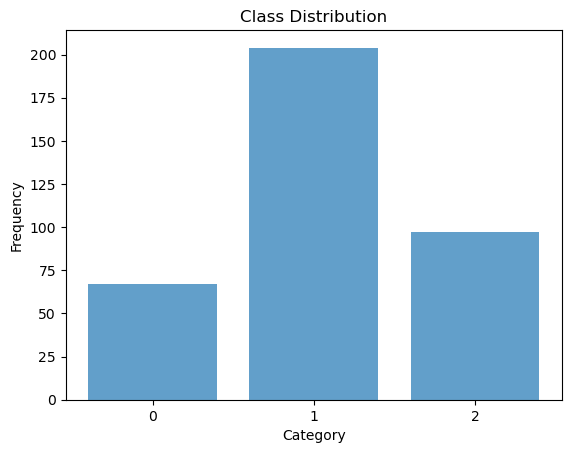

In [280]:
plt.bar(categories, category_counts, align='center', alpha=0.7)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(categories)
plt.show()

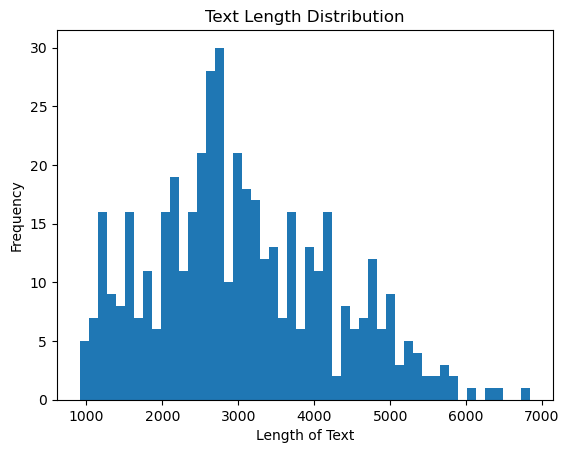

In [281]:
df['text_length'] = df['summary'].apply(lambda x: len(x.split()))
df['text_length'].plot(kind='hist', bins=50, title='Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

<h3>2_ Data pre-processing</h3><br>

C:\Users\Sky\AppData\Local\Temp\ipykernel_15080\4073940306.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

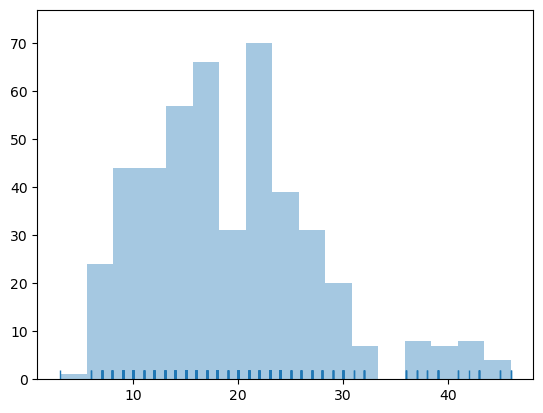

In [282]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X)), display_id=True)
for ii, txt in enumerate(X):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X)))

sns.distplot(sizes, kde=False, rug=True)

In [358]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [368]:
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)

In [369]:
# word_index is the dictionary that contains the index of each words in our 3000 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_test = keras_tokenizer.texts_to_sequences(X_test)

In [286]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : fund summary fund/class fidelity® emerging markets fund/fidelity® emerging markets fund investment objective fund seeks capital appreciation
Index sequences : [1, 10, 1, 7, 73, 69, 75, 1, 73, 69, 75, 1, 2, 3, 1, 6, 4, 14]


In [370]:
feature_train = pad_sequences(sequences_train,maxlen=maxlen,dtype=float,padding='post',truncating='post')
feature_test = pad_sequences(sequences_test,maxlen=maxlen,dtype=float,padding='post',truncating='post')

In [288]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 18
length of the paded first sequence : 150


Finally, we create our embedding matrix. This is a (2500,50) array filled with the vector's representation of the words in our vocabulary. The line i is the vector representation of the word that has the index i.

In [371]:
embedding_matrix = np.zeros((len(word_index)+1,word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Now that each text has been translated to a 150 long vector of word indexes and that we have a matrix that transform a word index to its vector representation, we are ready to implement the deep learning models.

<h3>3_ First Model : One dimensional Convolutional Neural Network</h3>

In [290]:
def tune_CNN_model(hp):
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index)+1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    
    CNN.add(Convolution1D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    CNN.add(MaxPooling1D(pool_size=hp.Choice('maxpool1_pool_size', values=[2, 3, 5])))
    
    CNN.add(Convolution1D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('conv2_kernal_size', values=[3, 5, 7])))
    CNN.add(MaxPooling1D(pool_size=hp.Choice('maxpool2_pool_size', values=[2, 3, 5])))
    
    CNN.add(Flatten())
    CNN.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))
    CNN.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.1)))
    CNN.add(Dense(units=3, activation='softmax'))
    
    CNN.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return CNN

In [291]:
stop_early = EarlyStopping(monitor='val_loss', patience=10)

We use the keras_tuner.Hyperband here to tune the hyperparameters instead of RandomSearch due to the number of hpyerparams in the CNN is large and Hyperband is more efficient in this case.

In [292]:
tuner = kt.Hyperband(tune_CNN_model,
                    objective='val_accuracy',
                    max_epochs=50,
                    factor=4,
                    directory='CNN_tuner_result',
                    project_name='nlp_model_tuning_1')

tuner.search(feature_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found were: ", best_hps.values)

Reloading Tuner from CNN_tuner_result\nlp_model_tuning_1\tuner0.json
Best hyperparameters found were:  {'conv1_filters': 96, 'conv1_kernel_size': 7, 'maxpool1_pool_size': 5, 'conv2_filters': 32, 'conv2_kernal_size': 7, 'maxpool2_pool_size': 3, 'dense_units': 128, 'dropout': 0.5, 'learning_rate': 0.0025319721581926594, 'tuner/epochs': 50, 'tuner/initial_epoch': 13, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0027'}


In [293]:
CNN_model = tune_CNN_model(best_hps)

After tuning the hyperparameters using the validation set, next we fit the model with the entire train data.  
And in order to show the performance on the test data, we need to set 'validation_data=(feature_test, y_test)' in the model fit function

In [294]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_test,y_test))

Epoch 1/10
23/23 [==============================] - 1s 13ms/step - loss: 1.0004 - accuracy: 0.5353 - val_loss: 0.9408 - val_accuracy: 0.5161
Epoch 2/10
23/23 [==============================] - 0s 7ms/step - loss: 0.7317 - accuracy: 0.6712 - val_loss: 0.6268 - val_accuracy: 0.7204
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 0.6112 - accuracy: 0.7500 - val_loss: 0.6451 - val_accuracy: 0.7097
Epoch 4/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4862 - accuracy: 0.8288 - val_loss: 0.4583 - val_accuracy: 0.8817
Epoch 5/10
23/23 [==============================] - 0s 6ms/step - loss: 0.4052 - accuracy: 0.8451 - val_loss: 0.4017 - val_accuracy: 0.8602
Epoch 6/10
23/23 [==============================] - 0s 6ms/step - loss: 0.3682 - accuracy: 0.8723 - val_loss: 0.4289 - val_accuracy: 0.8280
Epoch 7/10
23/23 [==============================] - 0s 7ms/step - loss: 0.2660 - accuracy: 0.8967 - val_loss: 0.4013 - val_accuracy: 0.8602
Epoch 8/10
23/23 [=

**Some visualizations of the training:**

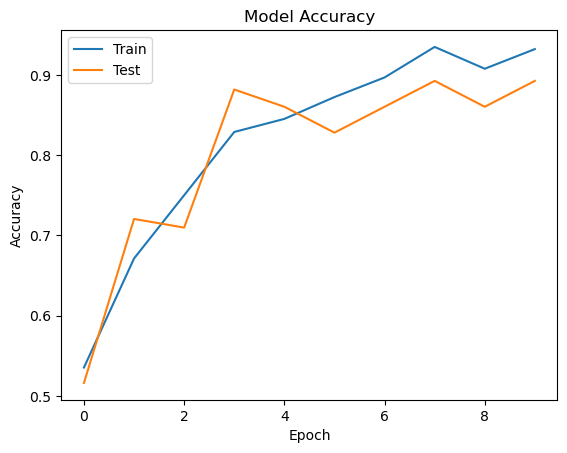

In [295]:
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

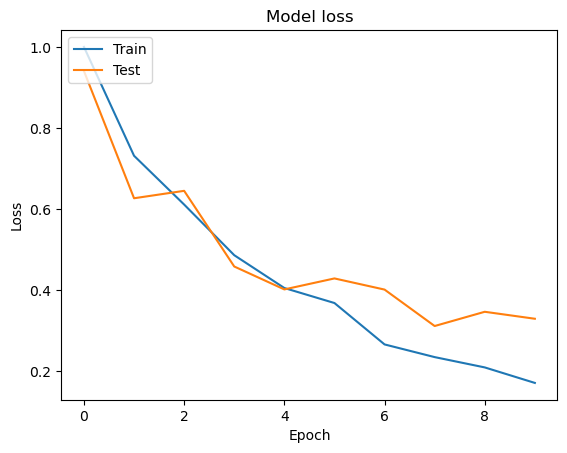

In [296]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Result evaluation:**

We can use the ROC curve to assess the performance of the classification.

In [297]:
y_pred_CNN = CNN_model.predict(feature_test)

3/3 [==============================] - 0s 4ms/step


In [298]:
num_classes = 3

In [299]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred_CNN[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

In [300]:
# Convert the original ONE HOT coded tags back into category tags
y_pred_CNN = np.argmax(y_pred_CNN, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test_labels, y_pred_CNN))
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred_CNN))

Confusion Matrix:
[[11  5  1]
 [ 1 41  1]
 [ 2  0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.89      0.95      0.92        43
           2       0.94      0.94      0.94        33

    accuracy                           0.89        93
   macro avg       0.87      0.85      0.86        93
weighted avg       0.89      0.89      0.89        93



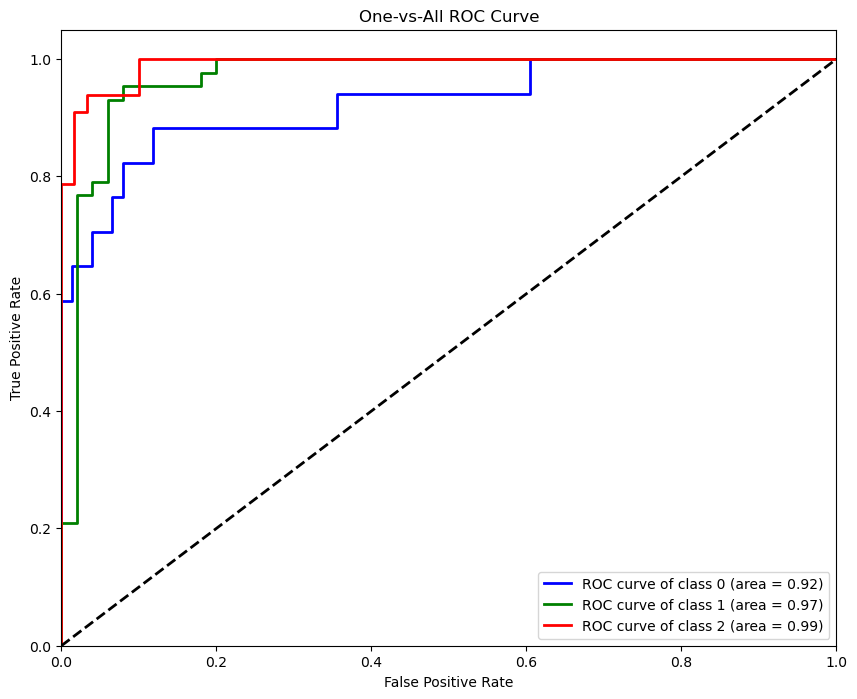

In [301]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'black']  
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()

<h3>4_ Second Model : Recurrent Neural Networks (with a Bidirectional LSTM layer instead of a simple RNN layer)</h3>

For RNN model, we will follow the below architect， which seems to behave the best after several validation

In [372]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index)+1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))
    
    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension,activation='relu'))
    RNN.add(Dense(3,activation='softmax'))
    RNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    
    return RNN

In [373]:
RNN_model = create_RNN_model()

Similar as above, we fit the model with the entire train data.
And in order to show the performance on the test data, we need to set 'validation_data=(feature_test, y_test)' in the model fit function

In [374]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=100, batch_size=16, validation_data=(feature_test,y_test), callbacks=[stop_early])

Epoch 1/100
23/23 [==============================] - 4s 60ms/step - loss: 1.0127 - accuracy: 0.5571 - val_loss: 1.0377 - val_accuracy: 0.4624
Epoch 2/100
23/23 [==============================] - 1s 33ms/step - loss: 0.9610 - accuracy: 0.5543 - val_loss: 1.0162 - val_accuracy: 0.4624
Epoch 3/100
23/23 [==============================] - 1s 35ms/step - loss: 0.8668 - accuracy: 0.6141 - val_loss: 0.9679 - val_accuracy: 0.5699
Epoch 4/100
23/23 [==============================] - 1s 30ms/step - loss: 0.7617 - accuracy: 0.7120 - val_loss: 0.7616 - val_accuracy: 0.7312
Epoch 5/100
23/23 [==============================] - 1s 32ms/step - loss: 0.7229 - accuracy: 0.7310 - val_loss: 0.7199 - val_accuracy: 0.7527
Epoch 6/100
23/23 [==============================] - 1s 34ms/step - loss: 0.6143 - accuracy: 0.7826 - val_loss: 0.6538 - val_accuracy: 0.7312
Epoch 7/100
23/23 [==============================] - 1s 33ms/step - loss: 0.5882 - accuracy: 0.7473 - val_loss: 0.5588 - val_accuracy: 0.7419
Epoch 

23/23 [==============================] - 1s 38ms/step - loss: 0.1273 - accuracy: 0.9620 - val_loss: 0.3583 - val_accuracy: 0.8710
Epoch 59/100
23/23 [==============================] - 1s 38ms/step - loss: 0.1491 - accuracy: 0.9565 - val_loss: 0.4181 - val_accuracy: 0.8387
Epoch 60/100
23/23 [==============================] - 1s 38ms/step - loss: 0.1543 - accuracy: 0.9620 - val_loss: 0.3148 - val_accuracy: 0.8925
Epoch 61/100
23/23 [==============================] - 1s 38ms/step - loss: 0.1156 - accuracy: 0.9647 - val_loss: 0.3698 - val_accuracy: 0.8387
Epoch 62/100
23/23 [==============================] - 1s 38ms/step - loss: 0.1423 - accuracy: 0.9457 - val_loss: 0.3519 - val_accuracy: 0.8710
Epoch 63/100
23/23 [==============================] - 1s 38ms/step - loss: 0.1112 - accuracy: 0.9647 - val_loss: 0.3072 - val_accuracy: 0.8817
Epoch 64/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0942 - accuracy: 0.9701 - val_loss: 0.2560 - val_accuracy: 0.9247
Epoch 65/100

**Some visualizations of the training:**

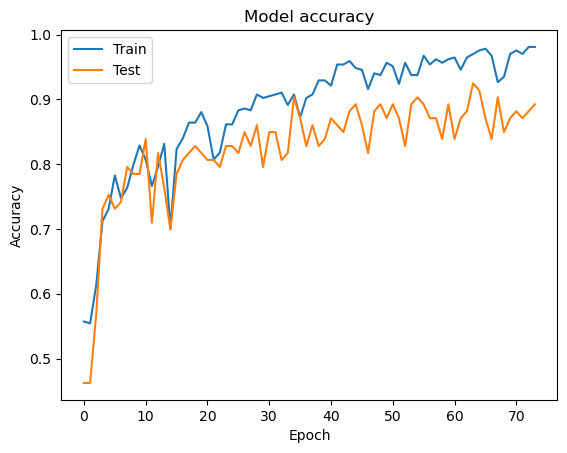

In [375]:
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

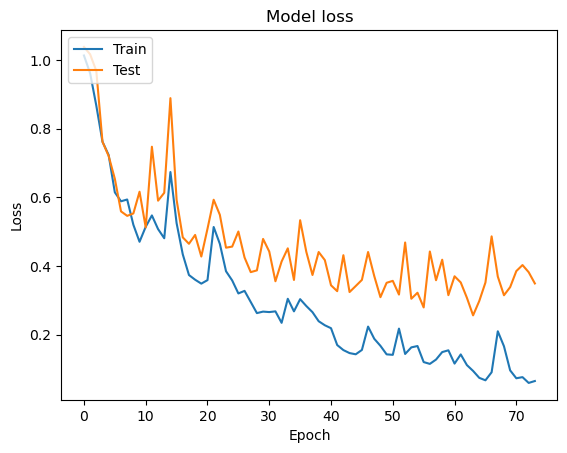

In [376]:
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

**Result evaluation:**

In [377]:
y_pred_RNN = RNN_model.predict(feature_test)

3/3 [==============================] - 1s 22ms/step


In [378]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i],y_pred_RNN[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

In [379]:
eval_result = RNN_model.evaluate(feature_test, y_test)
print("[test loss, test accuracy]:", eval_result)

3/3 [==============================] - 0s 18ms/step - loss: 0.3490 - accuracy: 0.8925
[test loss, test accuracy]: [0.3489598035812378, 0.8924731016159058]


In [380]:
y_pred_RNN = np.argmax(y_pred_RNN, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test_labels, y_pred_RNN))
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred_RNN))

Confusion Matrix:
[[12  4  1]
 [ 1 42  0]
 [ 1  3 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.86      0.98      0.91        43
           2       0.97      0.88      0.92        33

    accuracy                           0.89        93
   macro avg       0.89      0.85      0.87        93
weighted avg       0.90      0.89      0.89        93



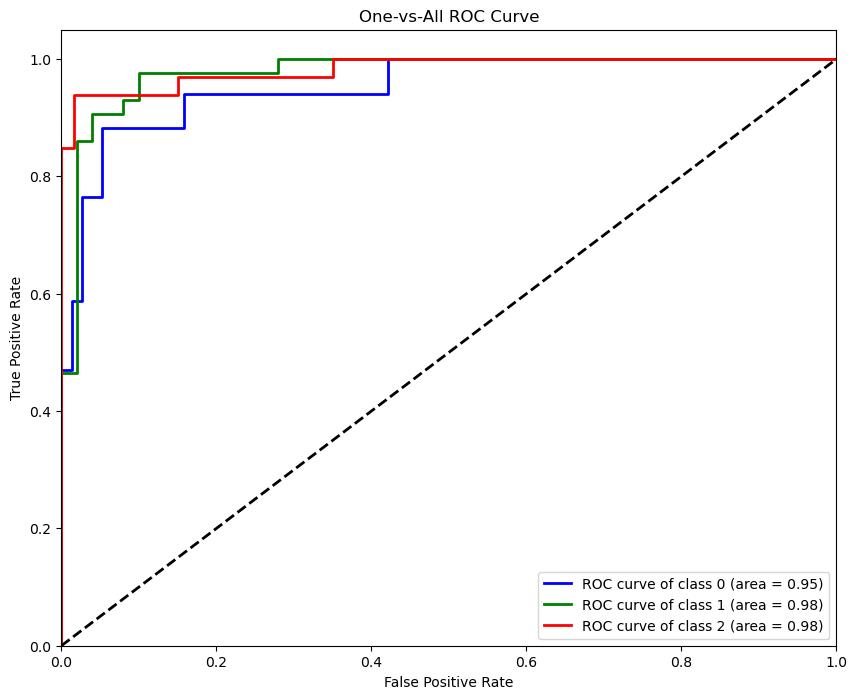

In [381]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'black']  
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()

<h3>5_ : Adopting the pre-trained word embedding model</h3>

In [312]:
glove_word2vec = 'glove.6B.50d.txt'

In [313]:
word2vec_g = load_word2vec(glove_word2vec)

We will use the same parameters and key words but different word_embeddings to generate a new glove-based knowledge base

In [314]:
knowledge_base_g = create_knowledge_base(8, word2vec, key_words)

In [315]:
sentence_barycentre = np.zeros(embedding_size)
df_g = df_filtered.copy()
df_g['invstrat_sentences_distance'] = df_g.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [316]:
X = df_g['invstrat_sentences_distance'].values
# Clean the texts
X = [' '.join(tokenizer(txt)) for txt in X]
y = df_g['Ivestment Strategy'].values

onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_labels = onehot_encoder.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels,test_size=0.2,random_state=42)

num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)

feature_train = pad_sequences(sequences_train,maxlen=maxlen,dtype=float,padding='post',truncating='post')

embedding_matrix_g = np.zeros((len(word_index)+1,word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec_g.get(word)
    if embedding_vector is not None:
        embedding_matrix_g[i] = embedding_vector

In [317]:
sequence_test = keras_tokenizer.texts_to_sequences(X_test)
feature_test = pad_sequences(sequence_test,maxlen=maxlen,dtype=float,padding='post',truncating='post')

In [318]:
stop_early = EarlyStopping(monitor='val_loss', patience=10)

Same as above we use the keras_tuner.Hyperband here to tune the hyperparameters

In [319]:
tuner2 = kt.Hyperband(tune_CNN_model,
                    objective='val_accuracy',
                    max_epochs=50,
                    factor=4,
                    directory='CNN_tuner_result',
                    project_name='nlp_model_tuning_2')


# 需要重新定义X_train, y_train
tuner2.search(feature_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found were: ", best_hps.values)

Reloading Tuner from CNN_tuner_result\nlp_model_tuning_2\tuner0.json
Best hyperparameters found were:  {'conv1_filters': 64, 'conv1_kernel_size': 3, 'maxpool1_pool_size': 5, 'conv2_filters': 64, 'conv2_kernal_size': 7, 'maxpool2_pool_size': 2, 'dense_units': 128, 'dropout': 0.2, 'learning_rate': 0.0014301446013786148, 'tuner/epochs': 50, 'tuner/initial_epoch': 13, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0031'}


In [320]:
CNN_model_g = tune_CNN_model(best_hps)

Similar as above, after tuning and get the best hyperparams, we fit the model with the entire train data. And in order to show the performance on the test data, we need to set 'validation_data=(feature_test, y_test)' in the model fit function

In [321]:
CNN_history_g = CNN_model_g.fit(feature_train, y_train, epochs=100, validation_data=(feature_test,y_test), callbacks=[stop_early])

Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 0.9728 - accuracy: 0.5489 - val_loss: 0.9252 - val_accuracy: 0.5591
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.8075 - accuracy: 0.6549 - val_loss: 0.8079 - val_accuracy: 0.5914
Epoch 3/100
12/12 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.6929 - val_loss: 0.7144 - val_accuracy: 0.6559
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.5681 - accuracy: 0.7636 - val_loss: 0.7238 - val_accuracy: 0.7097
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.4749 - accuracy: 0.8179 - val_loss: 0.5186 - val_accuracy: 0.8495
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.4103 - accuracy: 0.8424 - val_loss: 0.4246 - val_accuracy: 0.8710
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.3199 - accuracy: 0.8777 - val_loss: 0.4528 - val_accuracy: 0.8280
Epoch 8/100


**Some visualizations of the training:**

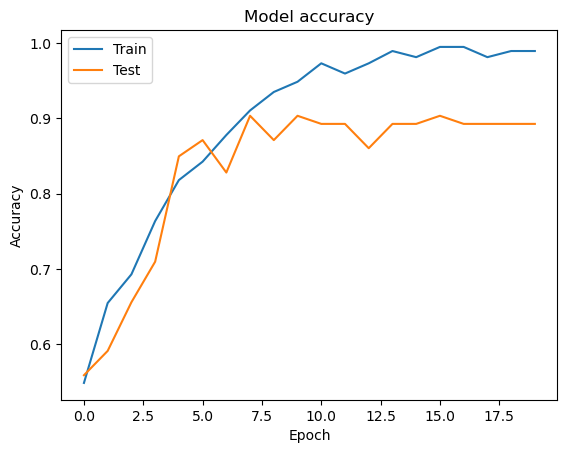

In [322]:
plt.plot(CNN_history_g.history['accuracy'])
plt.plot(CNN_history_g.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

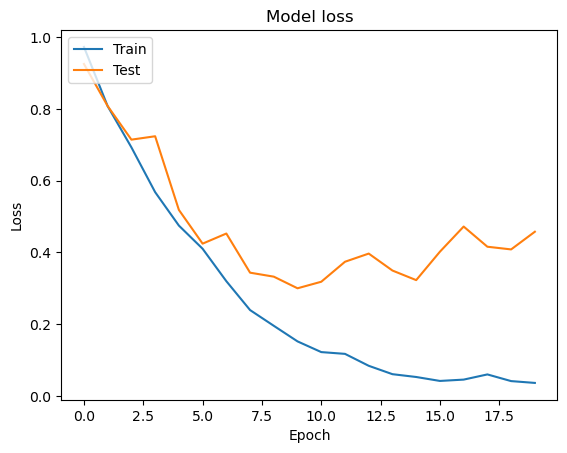

In [323]:
plt.plot(CNN_history_g.history['loss'])
plt.plot(CNN_history_g.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

**Result evaluation:**

In [324]:
eval_result_g = CNN_model_g.evaluate(feature_test, y_test)
print("[test loss, test accuracy]:", eval_result_g)

3/3 [==============================] - 0s 5ms/step - loss: 0.4578 - accuracy: 0.8925
[test loss, test accuracy]: [0.45776277780532837, 0.8924731016159058]


In [325]:
y_g_pred_CNN = CNN_model_g.predict(feature_test)

3/3 [==============================] - 0s 4ms/step


In [326]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i],y_g_pred_CNN[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

In [327]:
y_g_pred_CNN = np.argmax(y_g_pred_CNN, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test_labels, y_g_pred_CNN))
print('\nClassification Report:')
print(classification_report(y_test_labels, y_g_pred_CNN))

Confusion Matrix:
[[12  4  1]
 [ 0 38  5]
 [ 0  0 33]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        17
           1       0.90      0.88      0.89        43
           2       0.85      1.00      0.92        33

    accuracy                           0.89        93
   macro avg       0.92      0.86      0.88        93
weighted avg       0.90      0.89      0.89        93



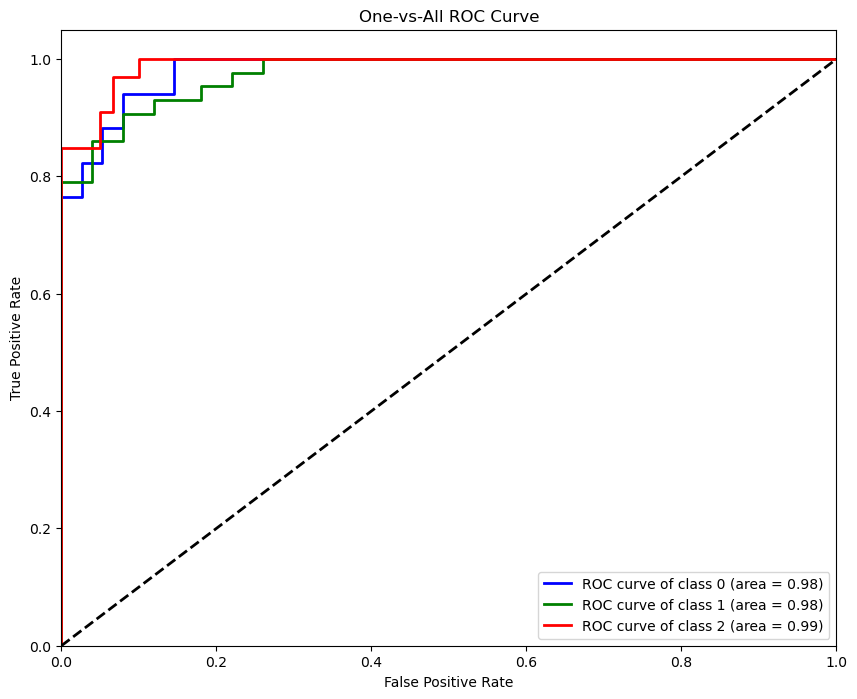

In [328]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'black']  
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()

**RNN results for glove word embedding:**

Similar as above, after tuning and get the best hyperparams, we fit the model with the entire train data. And in order to show the performance on the test data, we need to set 'validation_data=(feature_test, y_test)' in the model fit function

In [329]:
RNN_model_g = create_RNN_model()

In [330]:
RNN_history_g = RNN_model_g.fit(feature_train, y_train, epochs=100, validation_data=(feature_test,y_test), callbacks=[stop_early])

Epoch 1/100
12/12 [==============================] - 4s 102ms/step - loss: 0.9937 - accuracy: 0.5543 - val_loss: 1.0570 - val_accuracy: 0.4624
Epoch 2/100
12/12 [==============================] - 1s 51ms/step - loss: 0.9795 - accuracy: 0.5543 - val_loss: 1.0304 - val_accuracy: 0.4624
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 0.9522 - accuracy: 0.5543 - val_loss: 1.0117 - val_accuracy: 0.4624
Epoch 4/100
12/12 [==============================] - 1s 49ms/step - loss: 0.9021 - accuracy: 0.5734 - val_loss: 0.8965 - val_accuracy: 0.5591
Epoch 5/100
12/12 [==============================] - 1s 50ms/step - loss: 0.7572 - accuracy: 0.6658 - val_loss: 0.6768 - val_accuracy: 0.7419
Epoch 6/100
12/12 [==============================] - 1s 53ms/step - loss: 0.6990 - accuracy: 0.7065 - val_loss: 0.6827 - val_accuracy: 0.7419
Epoch 7/100
12/12 [==============================] - 1s 51ms/step - loss: 0.6653 - accuracy: 0.7582 - val_loss: 0.6727 - val_accuracy: 0.7742
Epoch

12/12 [==============================] - 1s 61ms/step - loss: 0.1795 - accuracy: 0.9348 - val_loss: 0.2932 - val_accuracy: 0.8602
Epoch 59/100
12/12 [==============================] - 1s 61ms/step - loss: 0.1315 - accuracy: 0.9511 - val_loss: 0.3502 - val_accuracy: 0.8817
Epoch 60/100
12/12 [==============================] - 1s 62ms/step - loss: 0.1148 - accuracy: 0.9647 - val_loss: 0.3135 - val_accuracy: 0.9032
Epoch 61/100
12/12 [==============================] - 1s 61ms/step - loss: 0.1066 - accuracy: 0.9674 - val_loss: 0.4085 - val_accuracy: 0.8602
Epoch 62/100
12/12 [==============================] - 1s 61ms/step - loss: 0.1099 - accuracy: 0.9620 - val_loss: 0.3409 - val_accuracy: 0.9032


**Some visualizations of the training:**

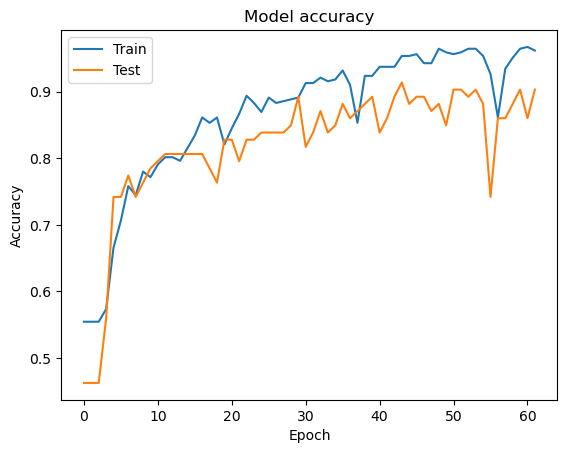

In [331]:
plt.plot(RNN_history_g.history['accuracy'])
plt.plot(RNN_history_g.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

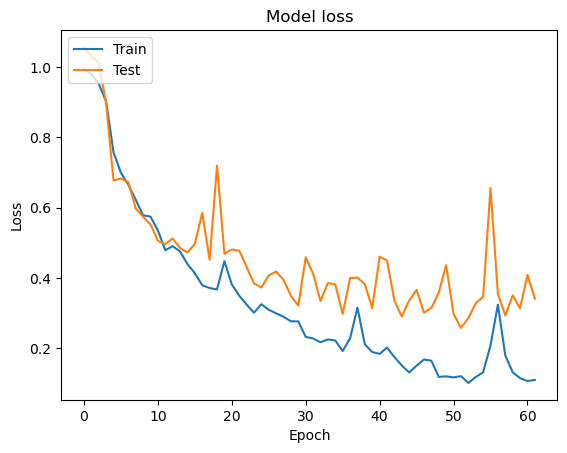

In [332]:
plt.plot(RNN_history_g.history['loss'])
plt.plot(RNN_history_g.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

**Result evaluation:**

In [333]:
eval_result_g = RNN_model_g.evaluate(feature_test, y_test)
print("[test loss, test accuracy]:", eval_result_g)

3/3 [==============================] - 0s 28ms/step - loss: 0.3409 - accuracy: 0.9032
[test loss, test accuracy]: [0.34092530608177185, 0.9032257795333862]


In [334]:
y_g_pred_RNN = RNN_model_g.predict(feature_test)

3/3 [==============================] - 1s 22ms/step


In [335]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_g_pred_RNN[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [336]:
y_g_pred_RNN = np.argmax(y_g_pred_RNN, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test_labels, y_g_pred_RNN))
print('\nClassification Report:')
print(classification_report(y_test_labels, y_g_pred_RNN))

Confusion Matrix:
[[11  5  1]
 [ 1 42  0]
 [ 2  0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.89      0.98      0.93        43
           2       0.97      0.94      0.95        33

    accuracy                           0.90        93
   macro avg       0.88      0.85      0.87        93
weighted avg       0.90      0.90      0.90        93



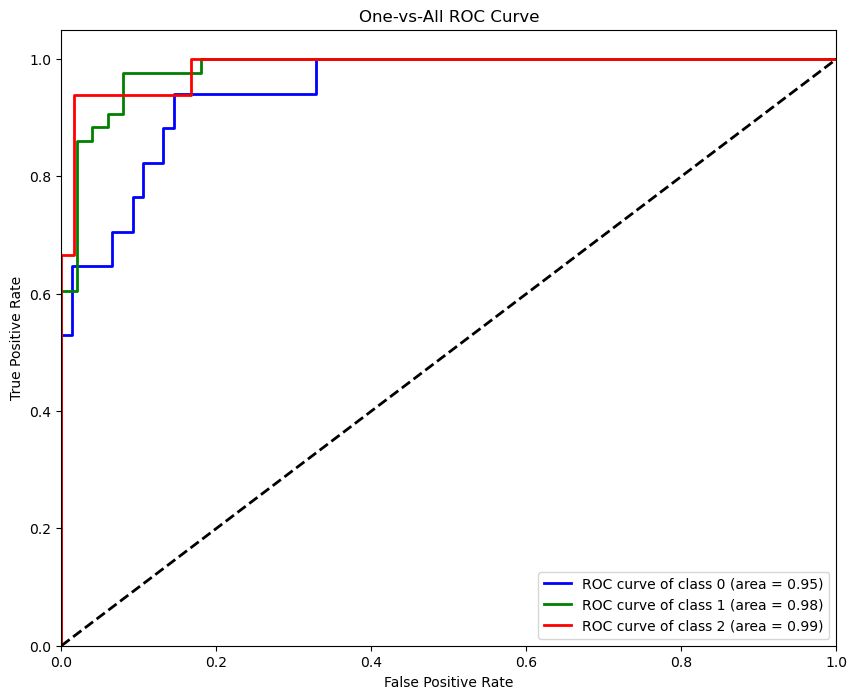

In [337]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'black']  
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()

# E_ Information extraction using sentence embedding instead of word embedding

In [338]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### Build embeddings for "summary", each summary are token to many sentences

In [339]:
y = df_filtered['Ivestment Strategy'].values

onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_labels = onehot_encoder.fit_transform(y.reshape(-1,1))

In [340]:
def extract_sentence_embedding_distance(summary,knowledge,n_closer,num_sent):
    sentences = sent_tokenize(summary)
    
    # we will not like the word_embedding to consider the frequency of sentence, each sentence will be used to calculate the distances
    sentence_embeddings = model.encode(sentences)
    
    keyword_embeddings = model.encode(list(knowledge))
    sentence_scores = []
    for j, sentence_embedding in enumerate(sentence_embeddings):
        distances = [cosine(sentence_embedding, kw_emb) for kw_emb in keyword_embeddings]
        distances.sort()
        
        score = np.mean(distances[:n_closer])
        
        sentence_scores.append(score)
    top_sentences_idx = np.argsort(sentence_scores)[:num_sent]
    top_sentences = [sentences[idx] for idx in top_sentences_idx]
    
    return ' '.join(top_sentences)

In this case, we keep the knowledge base generate by the glove word embeddings and extract the top closest sentences by the sentence embedding.

In [341]:
df_sen = df_filtered.copy()
df_sen['invstrat_sentences_distance'] = df_sen.apply(lambda x : extract_sentence_embedding_distance(x['summary'], knowledge_base, n_closer=10, num_sent=5), axis=1)

In [342]:
X = df_sen['invstrat_sentences_distance'].values

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels,test_size=0.2,random_state=42)

Since the sentence embedding is different from word embedding methods, we have obtained sentence embeddings through a very rich model 'sentence-transformers/all-MiniLM-L6-v2' that has converted the sentence into a compressed vector containing rich semantic information. This vector is a high-dimensional array of floating-point numbers that is no longer simply indexed by integers, so we can speak of it directly as an input to the neural network.

In [344]:
train_embeddings = model.encode(X_train)
test_embeddings = model.encode(X_test)

Again we will use the keras_tuner to tune and find the best model below.

In [345]:
def tune_sentence_embedding_classification(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(train_embeddings.shape[1],)))
    # Tuning the number of layers
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid'])
        ))

    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Tuning the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

We use 'RandomSearch' here, which is another approach compared with 'Hyperband'. Because the RandomSearch is able to provide sufficient options because the model is not so complex.

In [346]:
tuner3 = kt.RandomSearch(
    tune_sentence_embedding_classification,
    objective='val_loss',
    max_trials=30,  # Set more trials for a more thorough search.
    executions_per_trial=3,
    directory='Sentence_embedding_NNtuning',
    project_name='nlp_model'
)

In [347]:
tuner3.search(train_embeddings, y_train, epochs=200, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 58s]
val_loss: 0.7430008848508199

Best val_loss So Far: 0.5187167127927145
Total elapsed time: 00h 12m 13s


In [348]:
best_NN_model = tuner3.get_best_models(num_models=1)[0]
best_hyperparameters = tuner3.get_best_hyperparameters(num_trials=1)[0]

print(best_NN_model.summary())
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 49667 (194.01 KB)
Trainable params: 49667 (194.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'num_layers': 1, 'units_0': 128, 'activation_0': 'relu', 'learning_rate': 0.01, 'units_1': 224, 'activation_1': 'relu', 'units_2': 288, 'activation_2': 'sigmoid', 'units_3': 480, 'activation_3': 'relu'}


In [349]:
model_history = best_NN_model.fit(train_embeddings, y_train, epochs=100, batch_size = 16, validation_data=(test_embeddings, y_test), callbacks=[stop_early])

Epoch 1/100
23/23 [==============================] - 1s 8ms/step - loss: 0.3041 - accuracy: 0.8967 - val_loss: 0.6311 - val_accuracy: 0.8280
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2441 - accuracy: 0.9158 - val_loss: 0.6553 - val_accuracy: 0.8387
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.9293 - val_loss: 0.5976 - val_accuracy: 0.8602
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.2188 - accuracy: 0.9212 - val_loss: 0.6429 - val_accuracy: 0.8602
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.9239 - val_loss: 0.7040 - val_accuracy: 0.8710
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1208 - accuracy: 0.9701 - val_loss: 0.6552 - val_accuracy: 0.8817
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9565 - val_loss: 0.7767 - val_accuracy: 0.8710
Epoch 8/100
2

**Some visualizations of the training:**

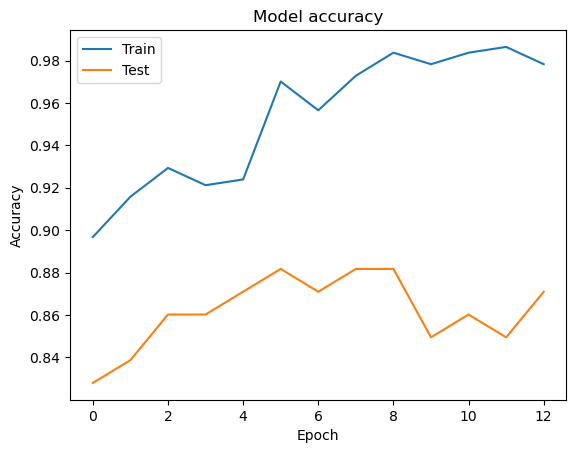

In [350]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

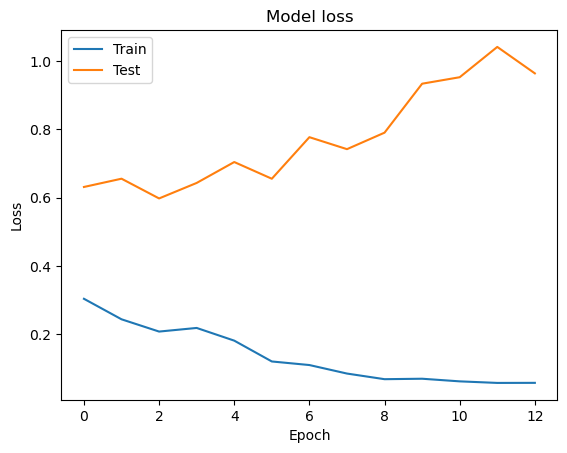

In [351]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

**Result evaluation:**

In [352]:
model_result = best_NN_model.evaluate(test_embeddings, y_test)
print("[test loss, test accuracy]:", model_result)

3/3 [==============================] - 0s 2ms/step - loss: 0.9633 - accuracy: 0.8710
[test loss, test accuracy]: [0.9633124470710754, 0.8709677457809448]


In [353]:
y_pred = best_NN_model.predict(test_embeddings)

3/3 [==============================] - 0s 1ms/step


In [354]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [355]:
y_pred = np.argmax(y_pred, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test_labels, y_pred))
print('\nClassification Report:')
print(classification_report(y_test_labels, y_pred))

Confusion Matrix:
[[12  5  0]
 [ 1 41  1]
 [ 0  5 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.80      0.95      0.87        43
           2       0.97      0.85      0.90        33

    accuracy                           0.87        93
   macro avg       0.90      0.84      0.86        93
weighted avg       0.88      0.87      0.87        93



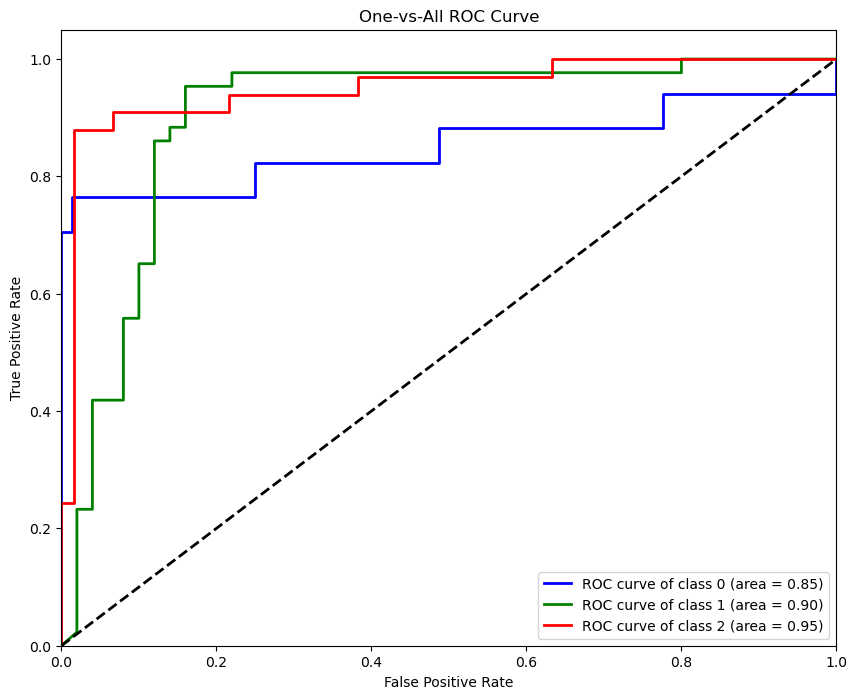

In [356]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'black']  
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve')
plt.legend(loc="lower right")
plt.show()